# Magics, Imports, and Versions

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import collections
import csv
import functools
import json
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
from pathlib import Path
import PIL
import pyedflib
import scipy
from scipy import signal
from subprocess import call
import sys
import typing
import urllib

In [3]:
plt.rcParams["figure.figsize"] = (10,10)

In [4]:
print(f'__Python VERSION: {sys.version}')

try:
    print(f'__pyTorch VERSION: {torch.__version__}')
    PYTORCH = True
except: 
    print("Pytorch Not Installed")
    PYTORCH = False

try:
    print(f'__fastai VERSION: {fastai.__version__}')
except:
    print("fastai Not Installed")
    
print('__CUDA VERSION')

! nvcc --version

if PYTORCH:
    print(f'__CUDNN VERSION: {torch.backends.cudnn.version()}')
    print(f'__Number CUDA Devices: {torch.cuda.device_count()}')
    
print(f'__Devices')

try:
    call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
    print(f'Active CUDA Device: GPU {torch.cuda.current_device()}')

    print (f'Available devices: {torch.cuda.device_count()}')
    print (f'Current cuda device {torch.cuda.current_device()}')
except:
    print("No GPUs Found")

__Python VERSION: 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
Pytorch Not Installed
fastai Not Installed
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
__Devices
No GPUs Found


# Path and Dirs

In [5]:
here = Path(f'{os.getcwd()}')
data_path = here.parent/'data'
raw_path = data_path/'raw'/'v1.5.0/edf'
with open(here.parent/'data_dict.json', 'r') as file:
     data_dict = json.load(file)
train_path=raw_path/'train'
test_path=raw_path/'dev_test'

In [6]:
def ensure_dir(directory):
    if not os.path.exists(directory):
        print(f'Creating {directory}')
        os.makedirs(directory)

In [7]:
ensure_dir(data_path/'images/test')
img_path = data_path/'images/test'

# Math Functions

In [8]:
def divergence(X):
    """ compute the divergence of n-D scalar field `X` """
    return scipy.ndimage.laplace(X)

In [34]:
def scale(X, maxi=255, mini=0):
    """ scale a n-D scalar field to [0-255] range for image creation """
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (maxi - mini) + mini
    return X_scaled

In [35]:
def convolve_8NNavg(F):
    """ compute the average of the 8 nearest neighbors for each point in the n-D scalar field `F` """
    """ https://gis.stackexchange.com/questions/254753/calculate-the-average-of-neighbor-pixels-for-raster-edge """
    return scipy.ndimage.generic_filter(F, np.nanmean, size=3, mode='constant', cval=np.NaN)

In [36]:
def convolve_8avg(array):
    kernel = np.array([[1, 1, 1],[1, 0, 1],[1, 1, 1]])
    n = kernel.sum()
    return scipy.ndimage.convolve(array, kernel, mode='nearest')/n

# Test and Transform

In [37]:
filename=str(train_path/'01_tcp_ar/009/00000906/s001_2003_04_23/00000906_s001_t000.edf')

In [38]:
CHANNEL_NAMES = ['EEG FP1-REF','EEG FP2-REF','EEG F8-REF','EEG F4-REF','EEG FZ-REF','EEG F3-REF','EEG F7-REF','EEG A1-REF','EEG T3-REF','EEG C3-REF','EEG CZ-REF','EEG C4-REF','EEG T4-REF','EEG A2-REF','EEG T6-REF','EEG P4-REF','EEG PZ-REF','EEG P3-REF','EEG T5-REF','EEG O1-REF','EEG O2-REF']

In [39]:
def get_eeg(filename):
    f = pyedflib.EdfReader(filename)
    n = f.signals_in_file
    duration = f.getFileDuration()
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((len(CHANNEL_NAMES), f.getNSamples()[0]))
    channel_list = [i for i,ch in enumerate(signal_labels) if ch in CHANNEL_NAMES]
    for idx, channel_index in enumerate(channel_list):
        sigbufs[idx, :] = f.readSignal(channel_index)
    return sigbufs, duration

In [40]:
data, duration = get_eeg(filename); duration

328

In [41]:
num = duration * 96
data = scipy.signal.resample(data, num=num, axis=1)
print(data.shape)
start_obs = int(2 * 96)
end_obs = int(3 * 96)
data = data[::,start_obs:end_obs]

(21, 31488)


In [42]:
def prange(*args):
    for array in args:
        print(array.min(), array.max())

In [43]:
data /=  np.linalg.norm(data, axis=1)[:,np.newaxis]

prange(data)

S = np.abs(np.fft.fft(data))
D = divergence(S)
I = convolve_8avg(D)

prange(S,D,I)

S = scale(S)
D = scale(D)
I = scale(I)

prange(S,D,I)

img = np.stack([S,D,I], axis=2)

prange(img[...,0], img[...,1], img[...,2])

img = PIL.Image.fromarray(img.astype(np.uint8), 'RGB').resize((224,224))
img = np.array(img)

0.026666853103180812 0.29189285190628395
0.0019114664811041848 9.726771883765513
-9.637748690330946 11.41778483454807
-2.4488595337681933 3.822675880881654
0.0 255.0
0.0 255.0
0.0 255.0
0.0 255.0
0.0 255.0
0.0 255.0


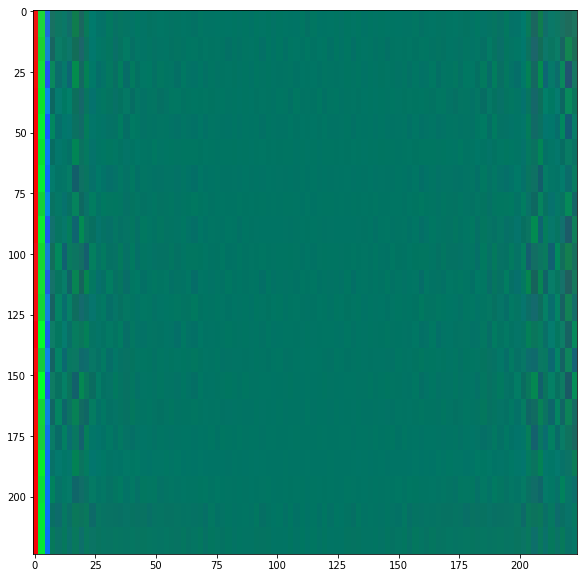

In [44]:
plt.imshow(img)

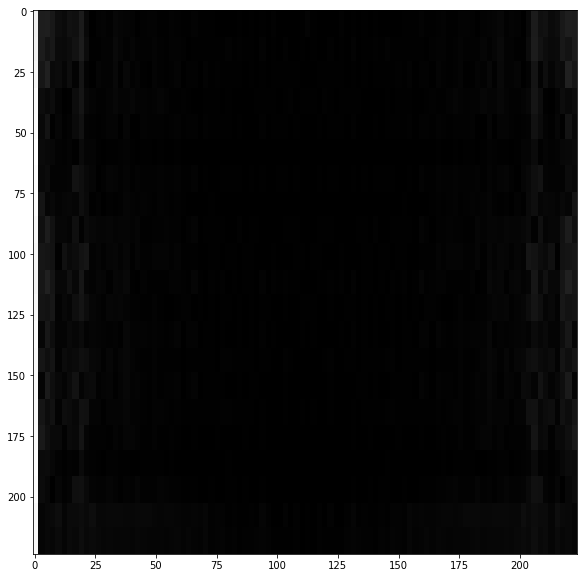

In [45]:
plt.imshow(img[...,0], cmap='gray')